In [1]:
# Import libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read in repeats file and column names file

df = pd.read_csv('/rds/projects/v/varnaic-schic-ml/Data/RepeatMasker/rmsk.txt', delimiter='\t')

# Step 1: Read the single row from the CSV file as a list of column names
column_names = pd.read_csv('columns_rmsk.csv', header=None).iloc[0].tolist()

# Step 2: Read the data from the TXT file without headers
data = pd.read_csv('/rds/projects/v/varnaic-schic-ml/Data/RepeatMasker/rmsk.txt', delimiter='\t', header=None)

# Step 3: Assign the column names to the DataFrame
data.columns = column_names

# Display the DataFrame
#print(data)

In [3]:
# Step 1: Filter to include only chr1 to chr19
chromosomes_to_keep = [f'chr{i}' for i in range(1, 20)]
filtered_data = data[data['genoName'].isin(chromosomes_to_keep)]

# Step 2: Remove repeat classes with '?' at the end
filtered_data = filtered_data[~filtered_data['repClass'].str.endswith('?')]

In [5]:
# Group by 'repClass' and count unique 'repName' for each 'repClass'
unique_repnames_per_class = filtered_data.groupby('repClass')['repName'].nunique().reset_index()

# Rename the columns for clarity
unique_repnames_per_class.columns = ['repClass', 'Unique_repName_Count']

# Display the result
#print(unique_repnames_per_class)

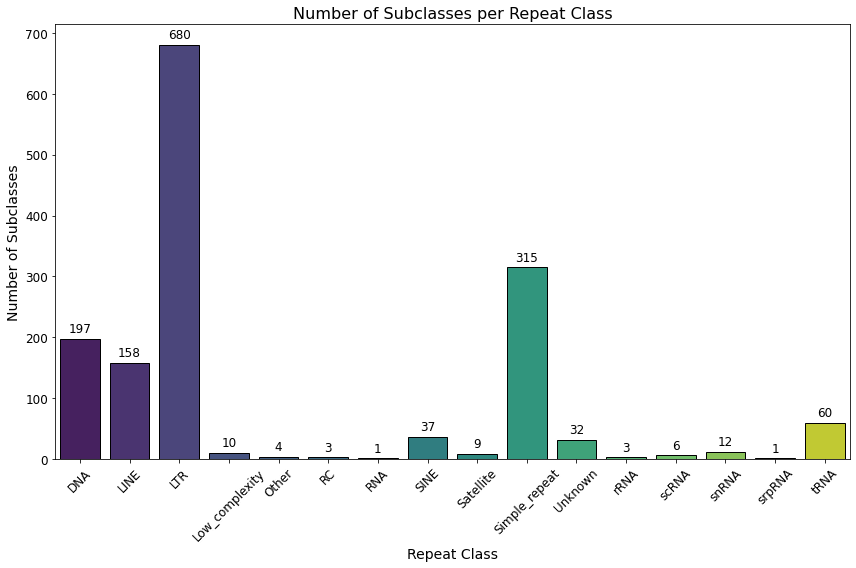

In [6]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a bar plot 
barplot = sns.barplot(x='repClass', y='Unique_repName_Count', data=unique_repnames_per_class, 
                      palette='viridis', edgecolor='black')

# Annotate each bar with the count value
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 10), 
                     textcoords='offset points', fontsize=12, color='black')  # Increased font size

# Set plot title and labels with larger font size
plt.title('Number of Subclasses per Repeat Class', fontsize=16)
plt.xlabel('Repeat Class', fontsize=14)
plt.ylabel('Number of Subclasses', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels and increase font size
plt.yticks(fontsize=12)  # Increase y-axis ticks font size

plt.tight_layout()  # Adjust layout to make room for label rotation

# Save the bar plot as a high-resolution image
#plt.savefig('number_subclasses.jpg', dpi=300, bbox_inches='tight')
plt.show()

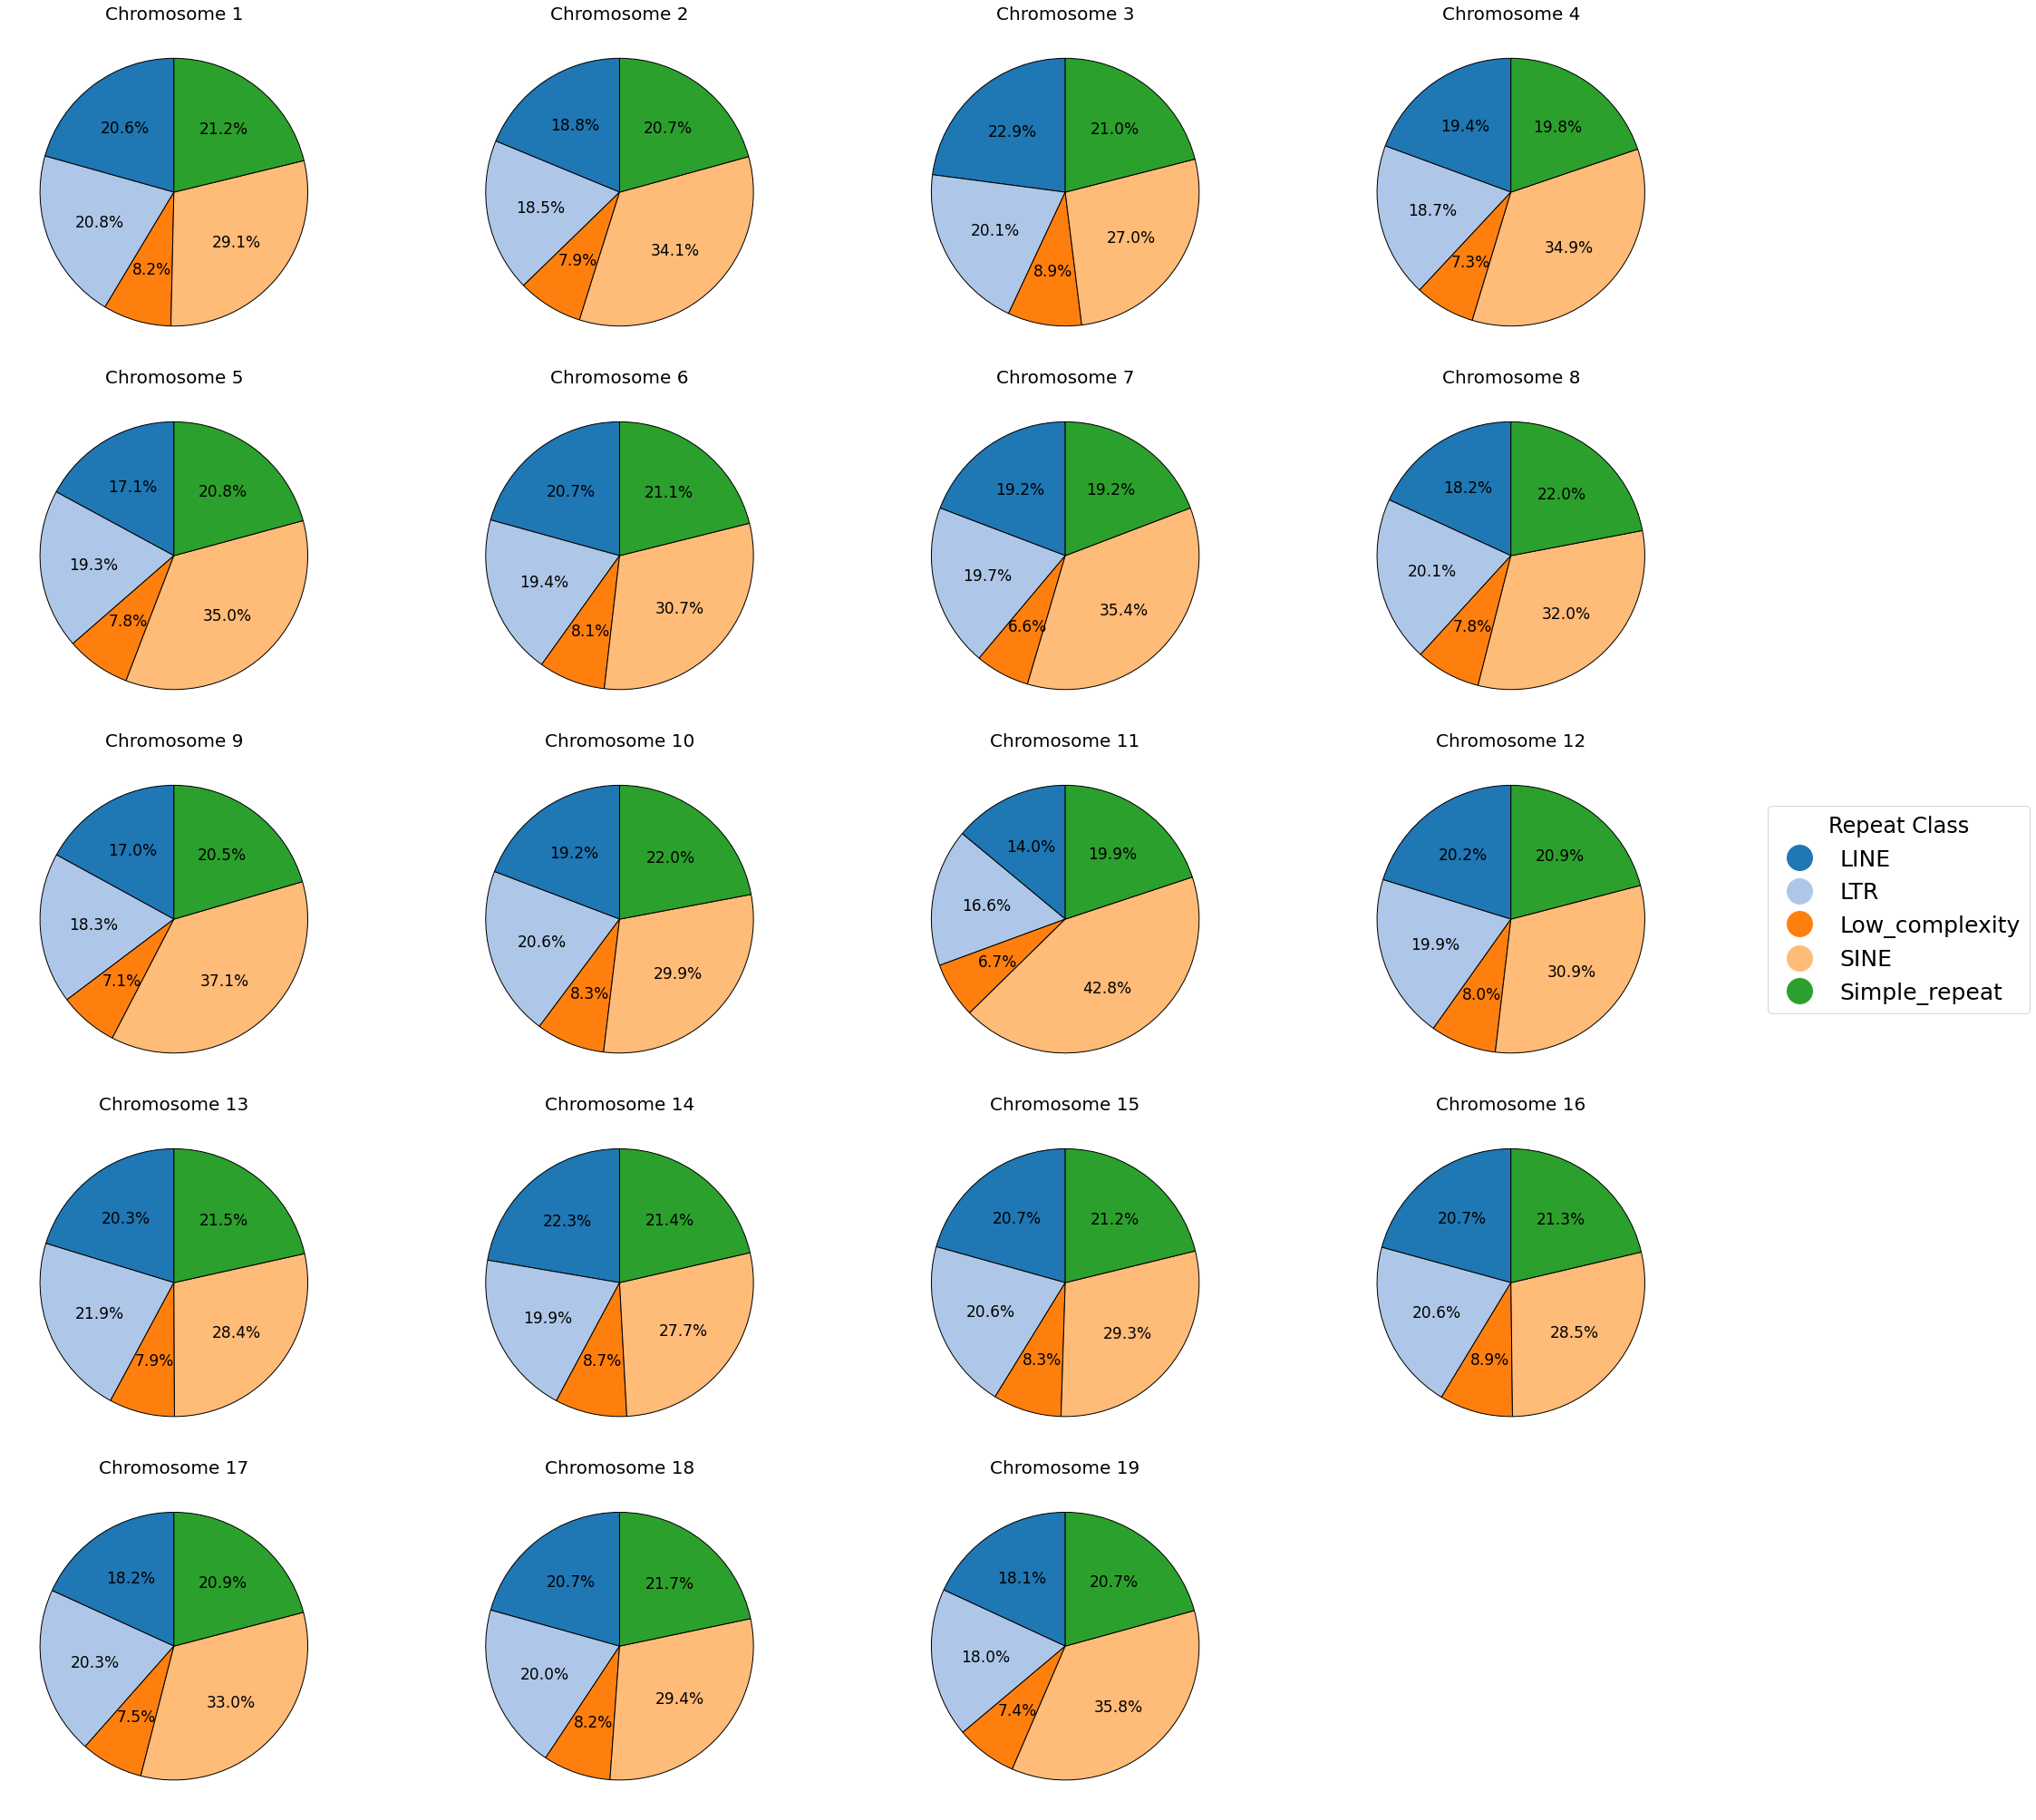

In [7]:
# Create pie charts to visualise distributions

# Function to conditionally display percentage values greater than 5%
def autopct_func(pct):
    return ('%1.1f%%' % pct) if pct > 5 else ''

# Group by 'genoName' and 'repClass', then count occurrences
repclass_counts = filtered_data.groupby(['genoName', 'repClass']).size().reset_index(name='Count')

# Get unique chromosomes and sort lexicographically
chromosomes = sorted(repclass_counts['genoName'].unique(), key=lambda x: (int(x[3:]), x))

# Calculate the total counts per chromosome to determine percentages
repclass_counts['Total'] = repclass_counts.groupby('genoName')['Count'].transform('sum')
repclass_counts['Percentage'] = 100 * repclass_counts['Count'] / repclass_counts['Total']

# Identify which repeat classes to include in the legend
repeat_classes_to_include = repclass_counts[repclass_counts['Percentage'] > 5]['repClass'].unique()

# Create a color palette for repClass
repclass_palette = sns.color_palette('tab20', n_colors=len(repeat_classes_to_include))
repclass_colors = dict(zip(repeat_classes_to_include, repclass_palette))

# Set up the matplotlib figure for multiple subplots, making the figure larger
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(28, 28))  # Further increase figure size for larger pies
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

# Plot pie charts for each chromosome
for i, chrom in enumerate(chromosomes):
    ax = axes[i]
    
    # Filter data for the current chromosome
    chrom_data = repclass_counts[repclass_counts['genoName'] == chrom]
    
    # Filter to only include repeat classes with > 5% in the legend
    chrom_data = chrom_data[chrom_data['repClass'].isin(repeat_classes_to_include)]
    
    # Create a pie chart with black edges
    wedges, texts, autotexts = ax.pie(
        chrom_data['Count'],
        autopct=autopct_func,  # Only show percentages > 5%
        colors=[repclass_colors[repclass] for repclass in chrom_data['repClass']],
        startangle=90,
        labels=None,  # Exclude repClass names from pie slices
        wedgeprops=dict(edgecolor='black')  # Add black edges
    )
    
    # Set title with formatted chromosome name
    ax.set_title(f'Chromosome {int(chrom[3:])}', fontsize=20)  # Further increase the font size of the title
    
    # Style the percentage text with larger font
    for autotext in autotexts:
        autotext.set_fontsize(17)  # Further increase font size for percentages
        autotext.set_color('black')

# Create a legend with significantly larger text, including only the classes with > 5%
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=repclass_colors[repclass], markersize=30) 
           for repclass in repeat_classes_to_include]
labels = list(repeat_classes_to_include)
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Repeat Class', fontsize=25, title_fontsize=24)

# Remove empty subplots if there are fewer chromosomes than subplots
for j in range(len(chromosomes), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the pie chart plot as a high-resolution image
#plt.savefig('pie_charts2.jpg', dpi=300, bbox_inches='tight')
plt.show()

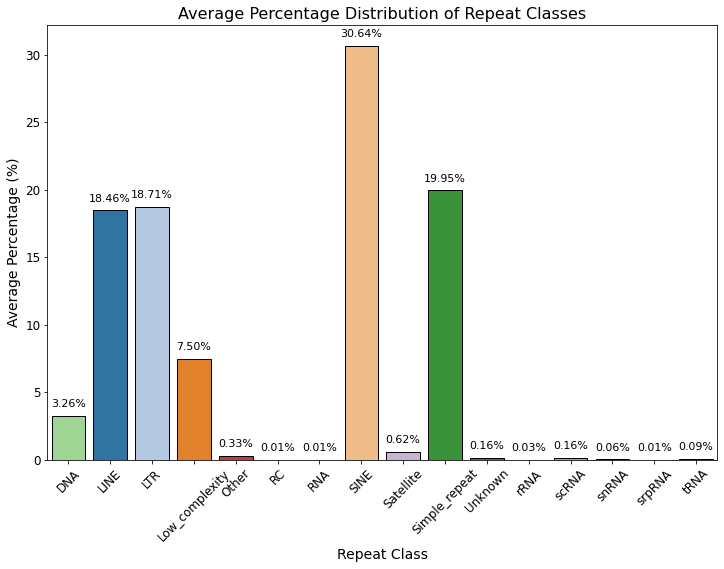

In [8]:
# Plot average distribution of repeats

# Group by 'genoName' and 'repClass', then count occurrences
repclass_counts = filtered_data.groupby(['genoName', 'repClass']).size().reset_index(name='Count')

# Get unique chromosomes and sort lexicographically
chromosomes = sorted(repclass_counts['genoName'].unique(), key=lambda x: (int(x[3:]), x))

# Create a tab20 color palette for repClass, assigning specific colors to selected classes
tab20_palette = sns.color_palette('tab20', n_colors=20)
repclass_order = ['LINE', 'LTR', 'Low_complexity', 'SINE', 'Simple_repeat']
custom_palette = {repclass: tab20_palette[i] for i, repclass in enumerate(repclass_order)}

# Assign the remaining colors to other repClasses
remaining_repclasses = [rc for rc in repclass_counts['repClass'].unique() if rc not in custom_palette]
for i, repclass in enumerate(remaining_repclasses, start=5):
    custom_palette[repclass] = tab20_palette[i]

# Initialize a DataFrame to store average percentages
avg_percentages = pd.DataFrame()

# Calculate percentages for each chromosome and average them
for chrom in chromosomes:
    chrom_data = repclass_counts[repclass_counts['genoName'] == chrom]
    percentages = chrom_data.set_index('repClass')['Count'] / chrom_data['Count'].sum() * 100
    percentages = percentages.reset_index(name='Percentage')
    percentages['Chromosome'] = chrom
    avg_percentages = pd.concat([avg_percentages, percentages], ignore_index=True)

# Calculate average percentage for each repClass
average_percentages = avg_percentages.groupby('repClass')['Percentage'].mean().reset_index()

# Plot average percentages with vertical bars
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='repClass', y='Percentage', data=average_percentages, palette=custom_palette)

# Add black edges to the bars
for patch in barplot.patches:
    patch.set_edgecolor('black')

# Annotate the bars with the percentage values using larger font
for index, value in enumerate(average_percentages['Percentage']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center', va='bottom', fontsize=11)

# Set title and labels with larger font size
plt.title('Average Percentage Distribution of Repeat Classes', fontsize=16)
plt.xlabel('Repeat Class', fontsize=14)
plt.ylabel('Average Percentage (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels if needed and increase their size
plt.yticks(fontsize=12)  # Increase y-axis label font size

# Save the plot as a high-resolution image
#plt.savefig('avg_dist.jpg', dpi=300, bbox_inches='tight')
plt.show()